<a href="https://colab.research.google.com/github/ayulockin/interpretabilitycnn/blob/master/CAM_W%26B_Way.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports, Installations and Setups

In [0]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.applications import VGG16

In [0]:
%%capture
!pip install wandb

In [0]:
import wandb
from wandb.keras import WandbCallback

wandb.login()

<IPython.core.display.Javascript object>

wandb: ERROR Not authenticated.  Copy a key from https://app.wandb.ai/authorize


API Key: ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [0]:
import os
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

import cv2

# Download Cat and Dog Dataset

In [0]:
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip \
    -O /tmp/cats_and_dogs_filtered.zip

--2020-04-27 10:02:40--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.142.128, 2607:f8b0:400e:c09::80
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.142.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘/tmp/cats_and_dogs_filtered.zip’

/tmp/cats_and_dogs_ 100%[===================>]  65.43M  74.6MB/s    in 0.9s    

2020-04-27 10:02:41 (74.6 MB/s) - ‘/tmp/cats_and_dogs_filtered.zip’ saved [68606236/68606236]



In [0]:
import zipfile

local_zip = '/tmp/cats_and_dogs_filtered.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

In [0]:
base_dir = '/tmp/cats_and_dogs_filtered'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

# Directory with our training cat pictures
train_cats_dir = os.path.join(train_dir, 'cats')

# Directory with our training dog pictures
train_dogs_dir = os.path.join(train_dir, 'dogs')

# Directory with our validation cat pictures
validation_cats_dir = os.path.join(validation_dir, 'cats')

# Directory with our validation dog pictures
validation_dogs_dir = os.path.join(validation_dir, 'dogs')

print('total training cat images:', len(os.listdir(train_cats_dir)))
print('total training dog images:', len(os.listdir(train_dogs_dir)))
print('total validation cat images:', len(os.listdir(validation_cats_dir)))
print('total validation dog images:', len(os.listdir(validation_dogs_dir)))

total training cat images: 1000
total training dog images: 1000
total validation cat images: 500
total validation dog images: 500


# Prepare Dataset

In [0]:
# All images will be rescaled by 1./255
train_datagen = ImageDataGenerator(rescale=1./255, 
                                   rotation_range=20, 
                                   horizontal_flip=True, 
                                   width_shift_range=0.1, 
                                   height_shift_range=0.1)

val_datagen = ImageDataGenerator(rescale=1./255)

# Flow training images in batches of 20 using train_datagen generator
train_generator = train_datagen.flow_from_directory(
        train_dir,  # This is the source directory for training images
        target_size=(224, 224),  # All images will be resized to 150x150
        batch_size=32,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='binary')

# Flow validation images in batches of 20 using val_datagen generator
validation_generator = val_datagen.flow_from_directory(
        validation_dir,
        target_size=(224, 224),
        batch_size=20,
        class_mode='binary')

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


# Model

In [0]:
def flatten_model(model_nested):
  '''
  Utility to flatten pretrained model
  '''
  layers_flat = []
  for layer in model_nested.layers:
      try:
          layers_flat.extend(layer.layers)
      except AttributeError:
          layers_flat.append(layer)
  
  return layers_flat

def CAMmodel():
  vgg = VGG16(include_top=False, weights='imagenet')
  vgg.trainable = False

  vgg_flat = flatten_model(vgg)
  vgg_flat.append(keras.layers.GlobalAveragePooling2D())
  vgg_flat.append(keras.layers.Dense(1, activation='sigmoid'))

  model = keras.models.Sequential(vgg_flat)

  return model

In [0]:
keras.backend.clear_session()
model = CAMmodel()
model.build((None, None, None, 3))
model.summary()

58892288/58889256 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0         
_________________________________________________________

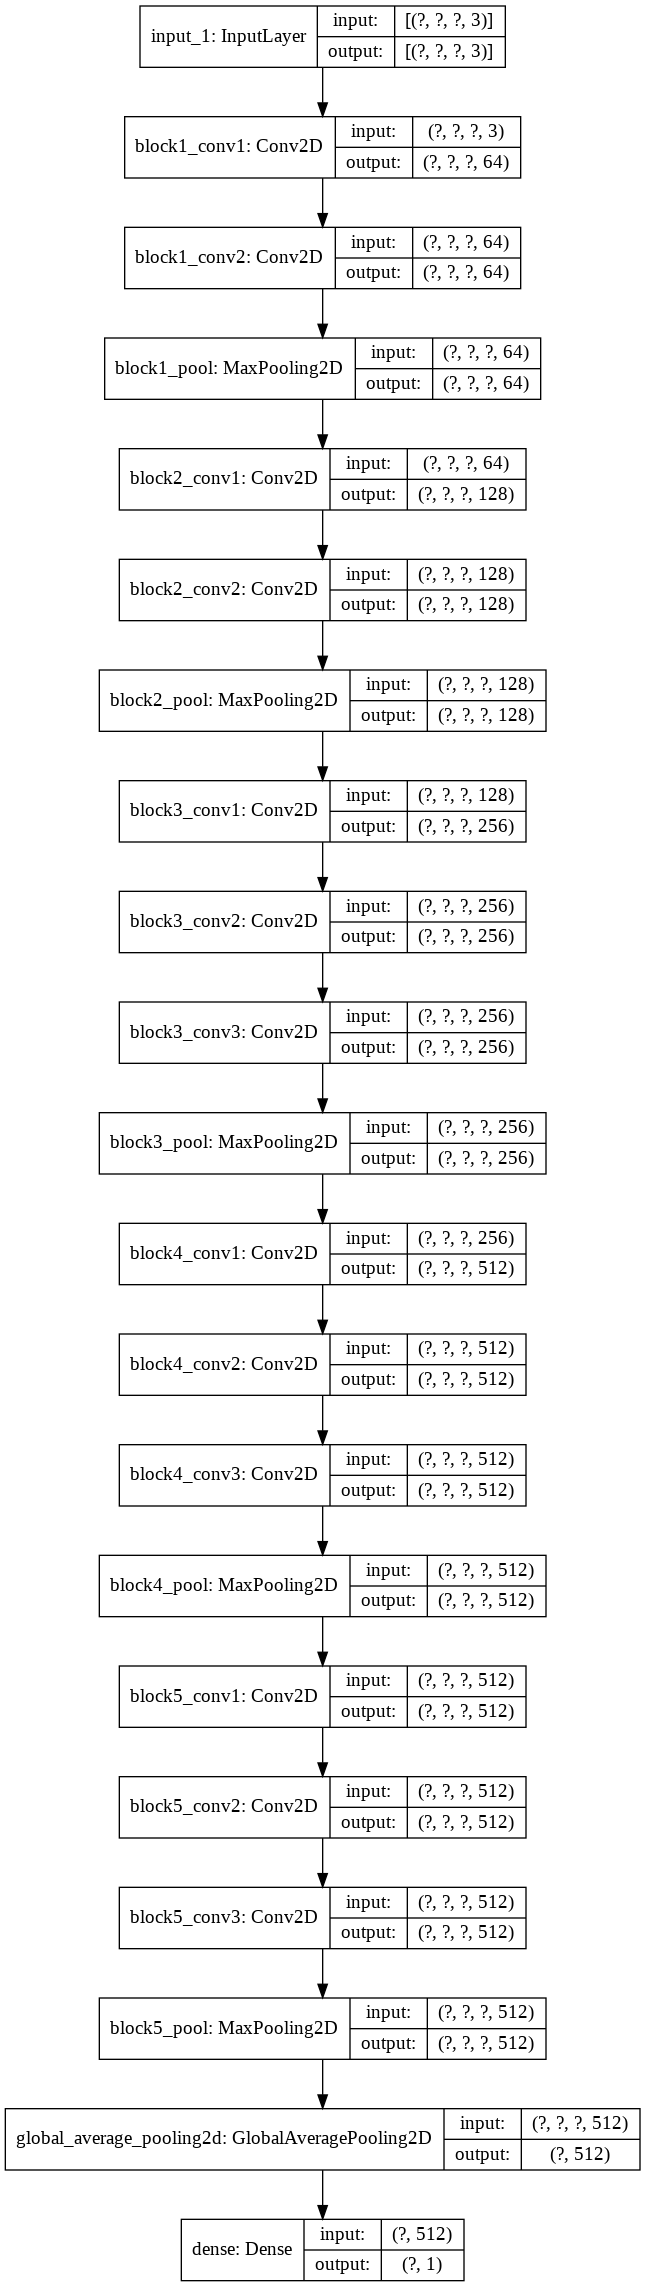

In [0]:
tf.keras.utils.plot_model(
    model, to_file='model.png', show_shapes=True, show_layer_names=True,
    rankdir='TB', expand_nested=True, dpi=96
)

# Compile


In [0]:
model.compile('adam', 'binary_crossentropy', ['acc'])

# W&B Init and Callback

In [0]:
class CAM:
  def __init__(self, model, layerName):
    self.model = model
    self.layerName = layerName
    
    last_conv_layer = self.model.get_layer(self.layerName).output
    self.cammodel = keras.models.Model(inputs=self.model.input,
                                       outputs=[last_conv_layer, self.model.output])
    
  def compute_heatmap(self, image, classIdx, eps=1e-8):
    [conv_outputs, predictions] = self.cammodel.predict(image)
    conv_outputs = conv_outputs[0, :, :, :]
    conv_outputs = np.rollaxis(conv_outputs, 2)

    class_weights = self.model.layers[-1].get_weights()[0]

    #Create the class activation map.
    caml = np.zeros(shape = conv_outputs.shape[1:3], dtype=np.float32)

    for i, w in enumerate(class_weights[:]):
      caml += w * conv_outputs[i, :, :]

    caml /= np.max(caml)
    caml = cv2.resize(caml, (image.shape[1], image.shape[2]))

    heatmap = cv2.applyColorMap(np.uint8(255*caml), cv2.COLORMAP_JET)

    heatmap[np.where(caml < 0.2)] = 0

    return heatmap

  def overlay_heatmap(self, heatmap, image):
    img = heatmap*0.5 + image

    img = img*255
    img = img.astype('uint8')

    return (heatmap, img)

In [0]:
class CamLogger(tf.keras.callbacks.Callback):
    def __init__(self, validation_data, layer_name):
      super(CamLogger, self).__init__()
      self.validation_data = validation_data
      self.layer_name = layer_name

    def on_epoch_end(self, logs, epoch):
      images = []
      grad_cam = []

      ## Initialize GRADCam Class
      cam = CAM(model, self.layer_name)

      for image in self.validation_data:
        image = np.expand_dims(image, 0)
        pred = model.predict(image)
        classIDx = np.argmax(pred[0])
  
        ## Compute Heatmap
        heatmap = cam.compute_heatmap(image, classIDx)
        
        image = image.reshape(image.shape[1:])

        ## Overlay heatmap on original image
        (heatmap, output) = cam.overlay_heatmap(heatmap, image)

        images.append(image)
        grad_cam.append(output)

      wandb.log({"images": [wandb.Image(image)
                            for image in images]})
      wandb.log({"gradcam": [wandb.Image(cam)
                            for cam in grad_cam]})

In [0]:
## Prepare sample images to run your GradCam on. 
sample_images, sample_labels = validation_generator[1]
sample_images.shape, sample_labels.shape

((20, 224, 224, 3), (20,))

In [0]:
wandb.init(entity='ayush-thakur', project='gradcam-wandb')

W&B Run: https://app.wandb.ai/ayush-thakur/gradcam-wandb/runs/3b39600i

# Train

In [0]:
history = model.fit(train_generator,
                    steps_per_epoch=300,
                    epochs=20,
                    validation_data=validation_generator,
                    validation_steps=50,
                    callbacks=[WandbCallback(data_type="image", validation_data=(sample_images, sample_labels), labels=["Cat", "Dog"]),
                               CamLogger(sample_images, 'block5_conv3')])

Epoch 1/20
300/300 [==============================] - 122s 406ms/step - loss: 0.4771 - acc: 0.8348 - val_loss: 0.4220 - val_acc: 0.8390
Epoch 2/20
300/300 [==============================] - 122s 408ms/step - loss: 0.4161 - acc: 0.8534 - val_loss: 0.3713 - val_acc: 0.8680
Epoch 3/20
300/300 [==============================] - 122s 407ms/step - loss: 0.3759 - acc: 0.8659 - val_loss: 0.3339 - val_acc: 0.8770
Epoch 4/20
300/300 [==============================] - 122s 407ms/step - loss: 0.3538 - acc: 0.8708 - val_loss: 0.3093 - val_acc: 0.8880
Epoch 5/20
300/300 [==============================] - 122s 407ms/step - loss: 0.3282 - acc: 0.8812 - val_loss: 0.3001 - val_acc: 0.8850
Epoch 6/20
300/300 [==============================] - 122s 407ms/step - loss: 0.3175 - acc: 0.8826 - val_loss: 0.2824 - val_acc: 0.8980
Epoch 7/20
300/300 [==============================] - 123s 411ms/step - loss: 0.2998 - acc: 0.8944 - val_loss: 0.2618 - val_acc: 0.9110
Epoch 8/20
300/300 [============================

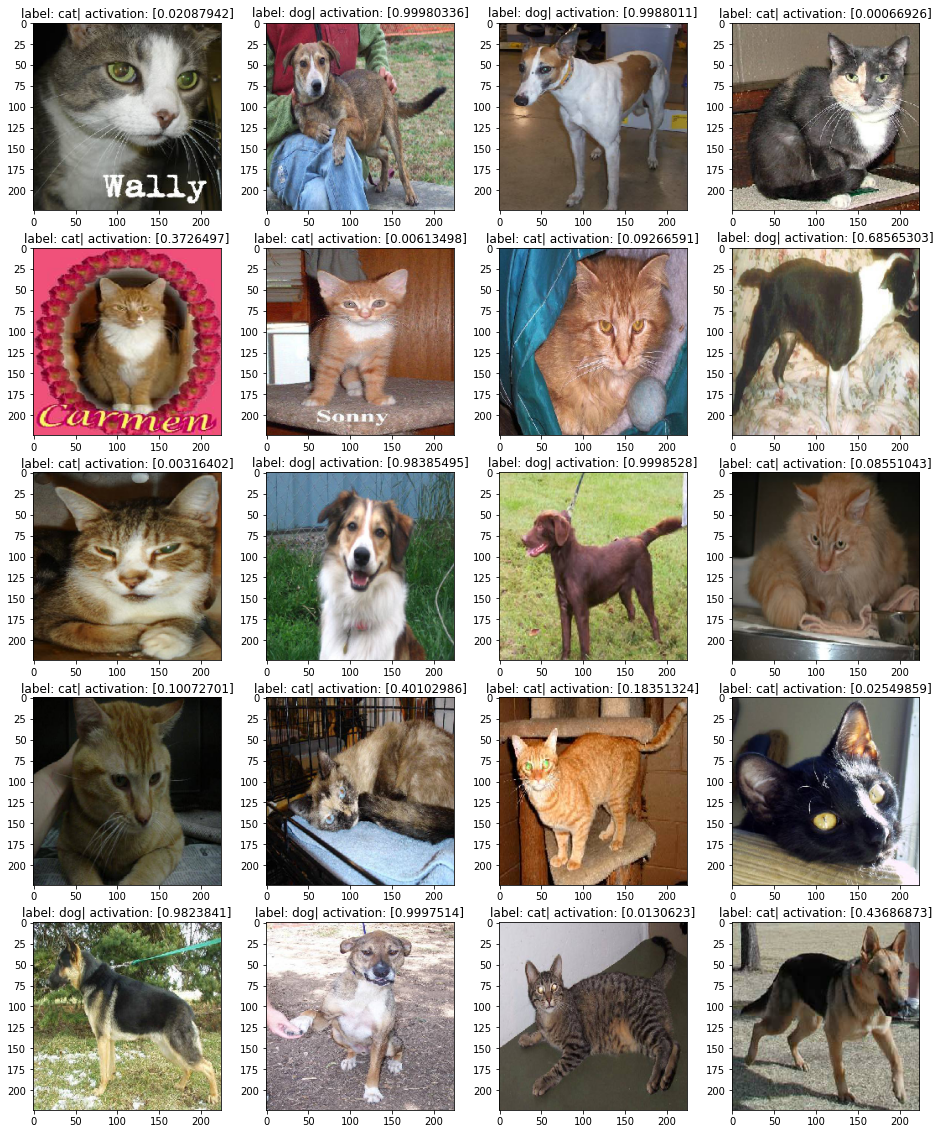

In [0]:
n_rows=len(sample_images)//4
n_cols=4 

fig, axs = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(16, 4*n_rows))

c = 0
for i in range(n_rows):
  for j in range(n_cols):
    image = np.expand_dims(sample_images[c], 0)
    pred = model.predict(image)
    if pred[0]>0.5:
      label='dog'
    else:
      label='cat'

    axs[i][j].imshow(sample_images[c]);
    axs[i][j].set_title('label: {}| activation: {}'.format(label, pred[0]));
    c+=1